# CMPE58Y Homework 3 : Policy Gradient with Function Approximation

M.Akın Elden \
2021700054

In [1]:
import pandas as pd
import numpy as np
import gym
import matplotlib.pyplot as plt

First define sigmoid function

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(x):
    s = sigmoid(x)
    return s * (1-s)

def dsigmoid_from_H(o):
    # here o is sigmoid(x)
    return o * (1-o)

Create a class to hold the network

In [3]:
class Network:
    def __init__(self, input_dim: int, layer_dims: list[int]):
        assert len(layer_dims) > 0
        self.n_layer = len(layer_dims)
        self.W = [np.random.randn(input_dim, layer_dims[0])*((2/(input_dim+layer_dims[0]))**0.5)]
        self.b = [np.zeros((1,layer_dims[0]))]
        for i in range(1, len(layer_dims)):
            self.W.append(np.random.randn(layer_dims[i-1], layer_dims[i]))
            self.b.append(np.zeros((1, layer_dims[i])))
        
        self.gradW = [np.zeros_like(w) for w in self.W]
        self.gradb = [np.zeros_like(b) for b in self.b]

    def forward(self, x: np.ndarray):
        # keep both activations and outputs in the memory
        Hs = [x.copy()]
        for W,b in zip(self.W, self.b):
            x = x @ W + b
            x = sigmoid(x)
            Hs.append(x.copy())
        return x, Hs

    def backward(self, d_error: np.ndarray, Hs: list[np.ndarray]):
        # n_x is the batch size
        n_x = d_error.shape[0]
        # keep layer errors
        layer_errors = [0 for i in range(len(self.W))]
        layer_errors[-1] = d_error

        self.gradW[-1] = (Hs[-2].T @ layer_errors[-1]) / n_x
        self.gradb[-1] = ( np.ones((1,n_x)) @ layer_errors[-1] ) / n_x
        for i in range(-2, -len(self.W)-1, -1): # reverse iterate hidden layers
            layer_errors[i] = dsigmoid_from_H(Hs[i])*(layer_errors[i+1] @ self.W[i+1].T)
            self.gradW[i] = (Hs[i-1].T @ layer_errors[i]) / n_x
            self.gradb[i] = (np.ones((1,n_x)) @ layer_errors[i]) / n_x
        return

    def update(self, lr: float):
        for i in range(len(self.W)):
            # since we are trying to maximize sum(y*logp*dr) not to minimize it, 
            # we move in positive gradient direction by addition
            self.W[i] = self.W[i] + lr * self.gradW[i]
            self.b[i] = self.b[i] + lr * self.gradb[i]

Create a class for Policy Gradient learning

In [4]:
class PolicyGradient:
    env : gym.Env
    network : Network
    rollouts: list
    scores : list[int]

    def __init__(self, env: gym.Env, input_dim: int, layer_dims: list[int], learning_rate=0.05, gamma=0.99):
        self.env = env
        self.max_episode = env._max_episode_steps
        self.network = Network(input_dim, layer_dims)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.scores = []
        self.rollouts = []
    
    def discount_and_baseline_rewards(self, rollout_rewards: list[list[float]]):
        discounted_rewards = [rewards.copy() for rewards in rollout_rewards]
        for ep_rewards, disc_rewards in zip(rollout_rewards, discounted_rewards):
            last_d_reward = 0
            # reverse iterate rewards and calculate discounted rewards with gamma
            for i in reversed(range(len(ep_rewards))):
                disc_rewards[i] = last_d_reward * self.gamma + ep_rewards[i]
                last_d_reward = disc_rewards[i]
        
        # create a matrix from discounted rewards and calculate baseline for each t
        disc_matrix = np.zeros((len(rollout_rewards), self.max_episode))
        for i, disc_rewards in enumerate(discounted_rewards):
            disc_matrix[i, 0:len(disc_rewards)] = disc_rewards
        
        baseline = np.mean(disc_matrix, axis=0)
        disc_matrix = disc_matrix - baseline
        discounted_rewards = [disc_matrix[i, 0:len(rewards)] for i, rewards in enumerate(rollout_rewards)]
        return discounted_rewards

    
    def train(self, n_rollouts, rollout_size=50, log = True):
        rollout = 0
        episode = 0
        while rollout < n_rollouts:
            rollout += 1
            rollout_Hs = [[] for i in range(self.network.n_layer+1)] # we keep a list for each layer output including input
            rollout_preds = []
            rollout_targets = []
            rollout_rewards = []
            
            while episode < rollout * rollout_size:
                # initialize for each episode:
                episode += 1
                score = 0
                done = False
                observation = self.env.reset()
                
                ep_rewards = [] # episode rewards

                while not done:
                    # for each step in episode
                    # first forward pass using current observation
                    p, currentHs = self.network.forward(np.array(observation).reshape(1,-1))
                    # then select action
                    action = 1 if np.random.uniform() < p else 0
                    y = action # we accept target is equal to action
                    # perform action and observe new state
                    observation, reward, done, _ = self.env.step(action)
                    score += reward
                    # record results
                    for rH, cH in zip(rollout_Hs, currentHs): rH.append(cH)
                    rollout_preds.append(p)
                    rollout_targets.append(y)
                    ep_rewards.append(reward)
                    
                    if done:
                        rollout_rewards.append(ep_rewards)
                        self.scores.append(score)
                        if log: print(f"Episode {episode} : {score}")
                    
            # When the rollout ends, calculate baseline and discounted rewards
            discounted_baseline_rewards = self.discount_and_baseline_rewards(rollout_rewards)
            # reshape rewards, predictions and targets to prepare matrix operations
            discounted_baseline_rewards = np.concatenate(discounted_baseline_rewards).reshape(-1,1)
            rollout_preds = np.array(rollout_preds).reshape(-1,1)
            rollout_targets = np.array(rollout_targets).reshape(-1,1)
            # gradient of logpi = pred_layer_error @ last_hidden_layer_output
            # pred_layer_error = [y * (1-p) - (1-y) * p] and since y is 0 or 1, it becomes
            # pred_layer_error = y - p
            # we multiply it last_hidden_layer_output inside backward function 
            # but we multiply it with discounted_baseline_rewards here
            d_error = (rollout_targets - rollout_preds) * discounted_baseline_rewards
            # backpropagate and update the weights
            self.network.backward(d_error, [np.array(Hs).reshape(len(Hs),-1) for Hs in rollout_Hs])
            self.network.update(self.learning_rate)

    def plot_scores(self, roll_size=100):
        data = pd.DataFrame({"scores" : self.scores})
        data["avg"] = data.scores.rolling(roll_size).mean()
        plt.figure(figsize=(12,6))
        plt.xlabel = "Episode"
        plt.ylabel = "Score"
        plt.plot(data["scores"], color="red", alpha=0.2)
        plt.plot(data["avg"], color="blue")
        plt.show()
    
    def run_visual(self, n_episode):
        score = 0
        episode = 0
        done = False
        observation = self.env.reset()
        while episode < n_episode:
            self.env.render()
            p, _ = self.network.forward(np.array(observation).reshape(1,-1))
            action = 1 if np.random.uniform() < p else 0
            observation, reward, done, _ = self.env.step(action)
            score += reward
            if done:
                episode+=1
                print(f"Episode {episode} : {score}")
                observation = self.env.reset()
                self.scores.append(score)
                score = 0

Initialize environment

In [5]:
env = gym.make('CartPole-v0')
env._max_episode_steps = 500

Train and plot the rewards

In [8]:
pg = PolicyGradient(env, input_dim=4, layer_dims=[4,1])
pg.train(n_rollouts=1000, rollout_size=50)

Episode 1 : 20.0
Episode 2 : 10.0
Episode 3 : 12.0
Episode 4 : 17.0
Episode 5 : 14.0
Episode 6 : 19.0
Episode 7 : 18.0
Episode 8 : 31.0
Episode 9 : 9.0
Episode 10 : 17.0
Episode 11 : 12.0
Episode 12 : 16.0
Episode 13 : 16.0
Episode 14 : 11.0
Episode 15 : 14.0
Episode 16 : 11.0
Episode 17 : 28.0
Episode 18 : 20.0
Episode 19 : 21.0
Episode 20 : 9.0
Episode 21 : 26.0
Episode 22 : 13.0
Episode 23 : 10.0
Episode 24 : 19.0
Episode 25 : 16.0
Episode 26 : 12.0
Episode 27 : 20.0
Episode 28 : 14.0
Episode 29 : 15.0
Episode 30 : 8.0
Episode 31 : 19.0
Episode 32 : 20.0
Episode 33 : 15.0
Episode 34 : 9.0
Episode 35 : 23.0
Episode 36 : 11.0
Episode 37 : 11.0
Episode 38 : 22.0
Episode 39 : 11.0
Episode 40 : 20.0
Episode 41 : 28.0
Episode 42 : 12.0
Episode 43 : 21.0
Episode 44 : 13.0
Episode 45 : 14.0
Episode 46 : 11.0
Episode 47 : 24.0
Episode 48 : 17.0
Episode 49 : 10.0
Episode 50 : 12.0
Episode 51 : 17.0
Episode 52 : 12.0
Episode 53 : 22.0
Episode 54 : 16.0
Episode 55 : 8.0
Episode 56 : 11.0
Episod

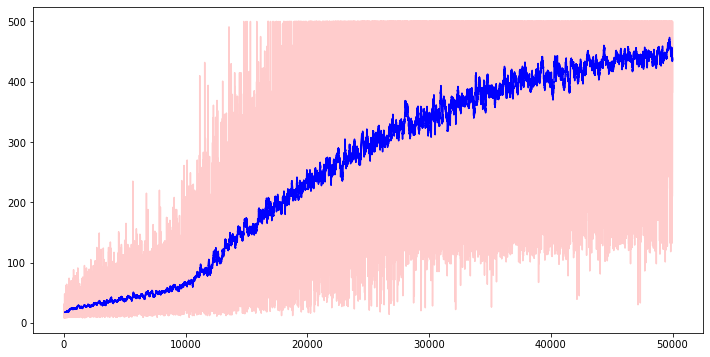

In [9]:
pg.plot_scores(roll_size=100)